In [29]:
import numpy as np
import matplotlib.pyplot as plt
import Qchains
import plotly.graph_objects as go
from scipy.spatial.distance import pdist, squareform
import trimesh
from sklearn.neighbors import NearestNeighbors

In [30]:
# Create a unit icosphere
sphere = trimesh.creation.icosphere(subdivisions=0.9, radius=1.0) #subdivison controls the size

sphere_points = sphere.vertices
print(sphere_points.shape)

(12, 3)


In [31]:
# Fit NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=6)  # include self
nbrs.fit(sphere_points)

# Find neighbors for each point
distances, indices = nbrs.kneighbors(sphere_points)

# Skip index 0 since it’s the point itself
nearest_6_neighbors = indices[:, 1:6]

def symmetric_rescale(sphere_points, nearest_6_neighbors, iterations=10, epsilon=0.1):
    sphere_points = sphere_points.copy()

    for _ in range(iterations):
        displacement = np.zeros_like(sphere_points)

        for i in range(len(sphere_points)):
            for j in nearest_6_neighbors[i]:
                if i >= j:
                    continue  # avoid double update
                direction = sphere_points[j] - sphere_points[i]
                dist = np.linalg.norm(direction)
                if dist == 0:
                    continue
                correction = epsilon * (1 - dist) * direction / dist
                displacement[i] -= correction / 2
                displacement[j] += correction / 2

        sphere_points += displacement

    return sphere_points

In [32]:
scaled_sphere_points = symmetric_rescale(sphere_points, nearest_6_neighbors, iterations= 100, epsilon=0.2)
np.linalg.norm(scaled_sphere_points[1]-scaled_sphere_points[0])

1.0000000000000004

In [33]:
new_point = np.array([[0.0, 0.0, 0.0]])
weird_sphere_scaled = np.vstack([scaled_sphere_points, new_point]) 

In [34]:
#Qchains.StructurePlotter(scaled_sphere_points) ## Instead of this we do it manually to add lines between neighbours

atoms = go.Scatter3d(
    x=scaled_sphere_points[:, 0],
    y=scaled_sphere_points[:, 1],
    z=scaled_sphere_points[:, 2],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Atoms'
)

# Create lines between atoms within bonding distance
D = squareform(pdist(scaled_sphere_points))

bond_length = 1
tolerance = 0.001

# Only draw edges where distance ≈ bond length
edges = []
for i in range(len(scaled_sphere_points)):
    for j in range(i + 1, len(scaled_sphere_points)):
        dist = np.linalg.norm(scaled_sphere_points[i] - scaled_sphere_points[j])
        if abs(dist - bond_length) < tolerance:
            edges.append(go.Scatter3d(
                x=[scaled_sphere_points[i, 0], scaled_sphere_points[j, 0], None],
                y=[scaled_sphere_points[i, 1], scaled_sphere_points[j, 1], None],
                z=[scaled_sphere_points[i, 2], scaled_sphere_points[j, 2], None],
                mode='lines',
                line=dict(color='gray', width=2),
                showlegend=False
            ))


# Combine all objects
fig = go.Figure(data=[atoms] + edges)
fig.update_layout(
    title='Interactive icosphere',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        aspectmode='data'
    )
)

fig.show()

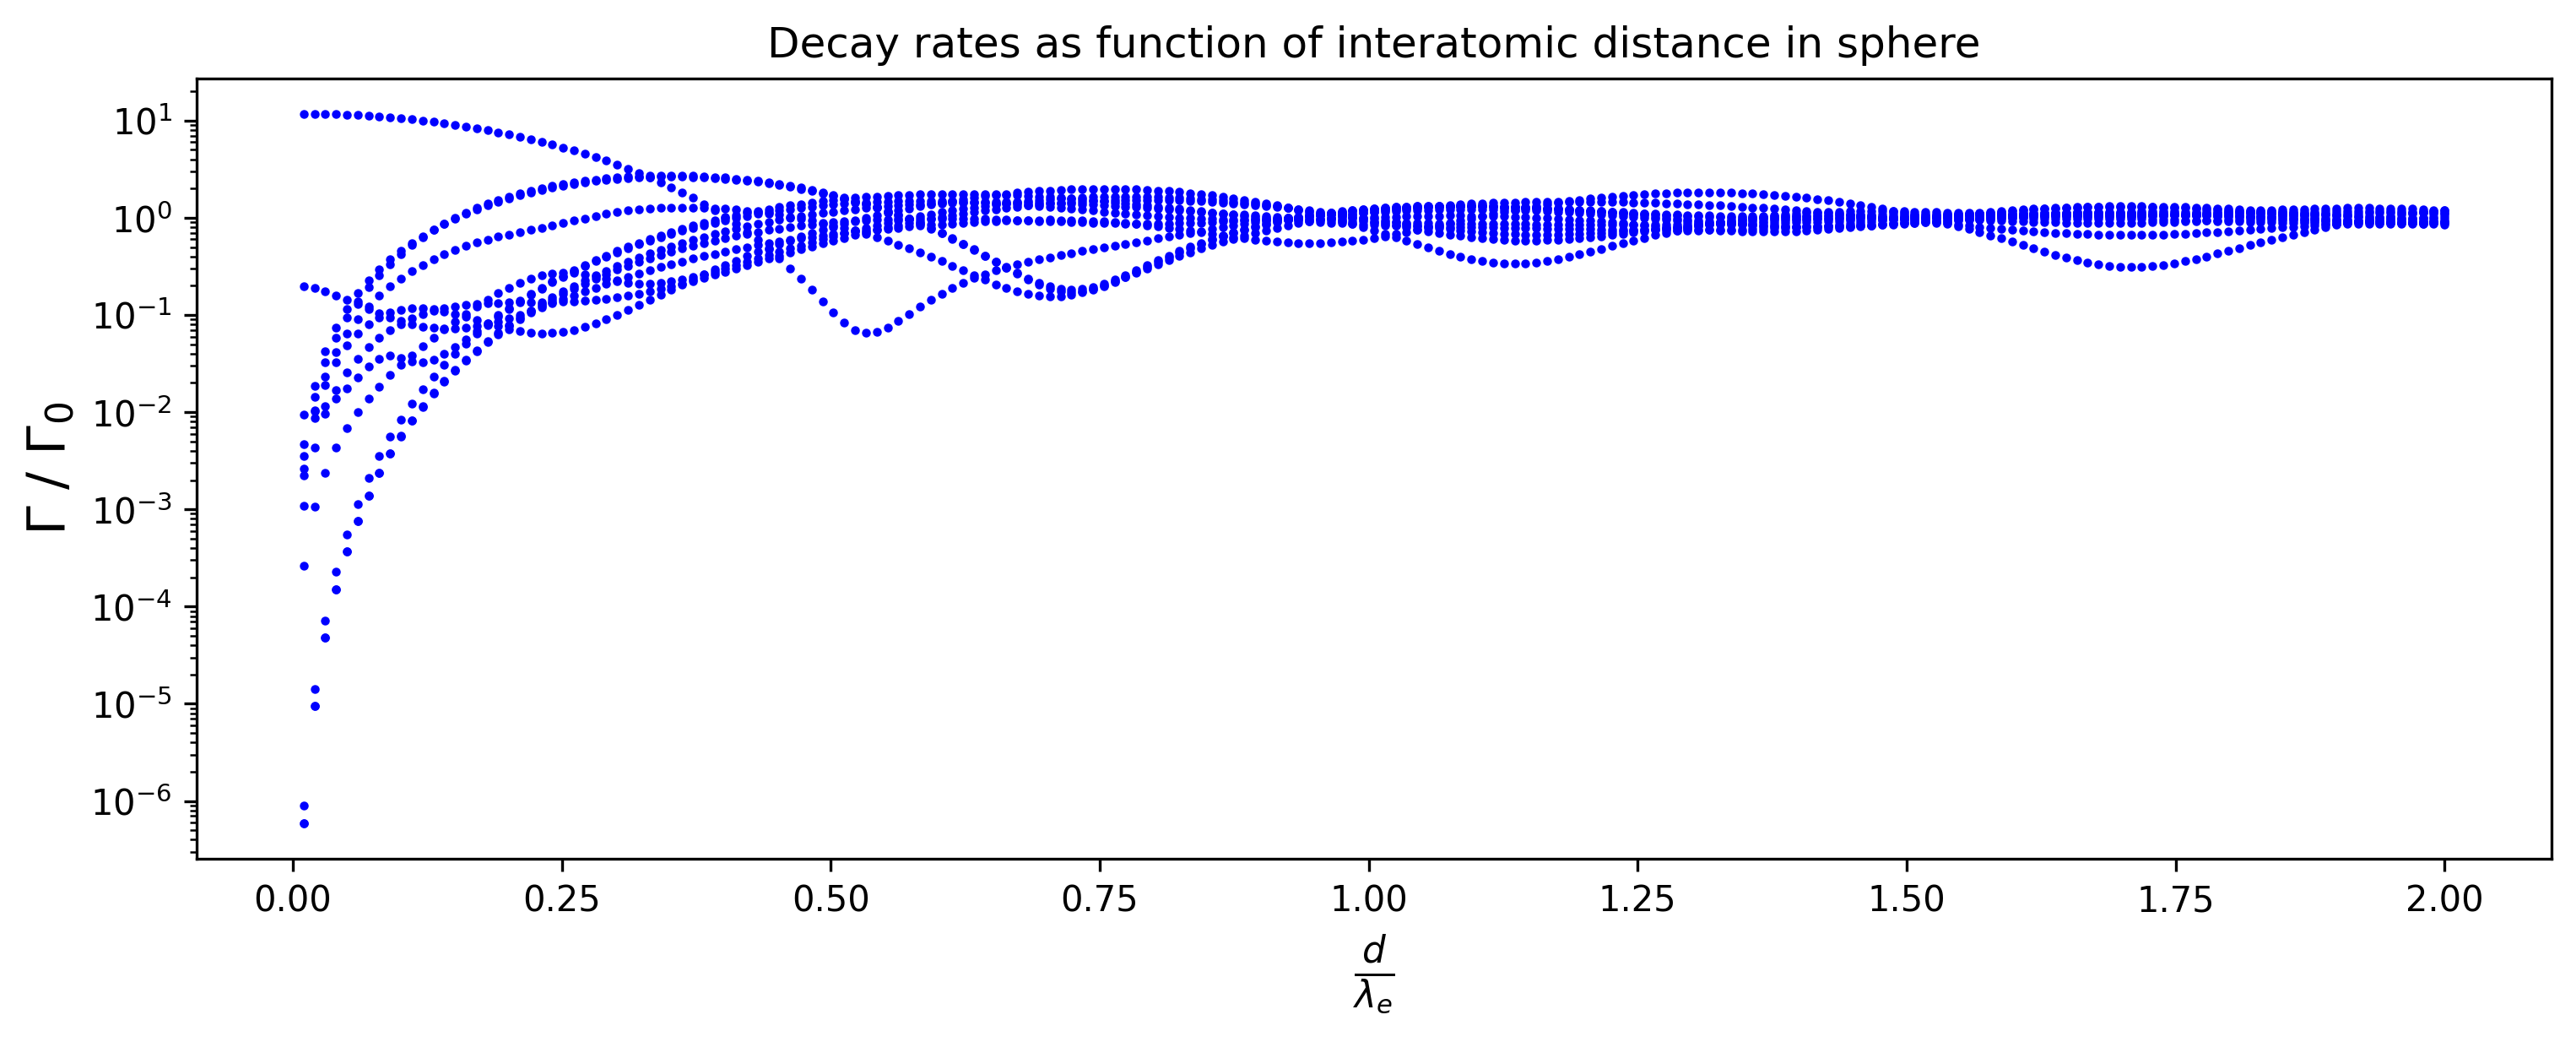

In [35]:
dipole_hatvec = np.array([1, 0, 0])
decay_rate_list = []
most_subradiant_list = []
distances = np.linspace(0, 2, 200) 

for d in distances[1:]:
    eigvals_sphere12 , eigvec_sphere12 = Qchains.FindEigenstates(scaled_sphere_points, dipole_hatvec, d)
    decay_rate = 2 * eigvals_sphere12.real
    decay_rate_list.append(decay_rate)

    subradiant = -np.max(2 * eigvals_sphere12.real)
    most_subradiant_list.append(subradiant)
    

decay_rate_list_reversed = [-p for p in decay_rate_list]
plt.figure(figsize=(12,4), dpi=300)
plt.plot(distances[1:], decay_rate_list_reversed, '.', c = 'blue', markersize=3);
plt.xlabel(r'$\frac{d}{\lambda_e}$', size = 15)
plt.ylabel(r'$\Gamma$ / $\Gamma_0$', size = 15)
plt.title('Decay rates as function of interatomic distance in sphere')
plt.yscale('log')

#### Try for hedgehog version

In [36]:
magnitudes_n = np.linalg.norm(scaled_sphere_points, axis=1, keepdims=True) 
unit_polarization = scaled_sphere_points / magnitudes_n

In [37]:
# Extract origin and vector components
x0, y0, z0 = scaled_sphere_points[:, 0], scaled_sphere_points[:, 1], scaled_sphere_points[:, 2]
u, v, w = unit_polarization[:, 0], unit_polarization[:, 1], unit_polarization[:, 2]

fig = go.Figure()

# Add 3D scatter of the sphere points
fig.add_trace(go.Scatter3d(
    x=x0, y=y0, z=z0,
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Sphere points'
))

# Add vector field as cones
fig.add_trace(go.Cone(
    x=x0, y=y0, z=z0,
    u=u, v=v, w=w,
    sizemode="absolute",
    sizeref=0.5,  # Adjust this to control arrow size
    anchor="tail",  # Origin of vector is at the point
    colorscale="Hot",
    showscale=False,
    name='Vectors',
    lighting=dict(ambient=1, diffuse=0, specular=0, roughness=0, fresnel=0)
))

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    title='Vector Field on Sphere'
)

fig.show()


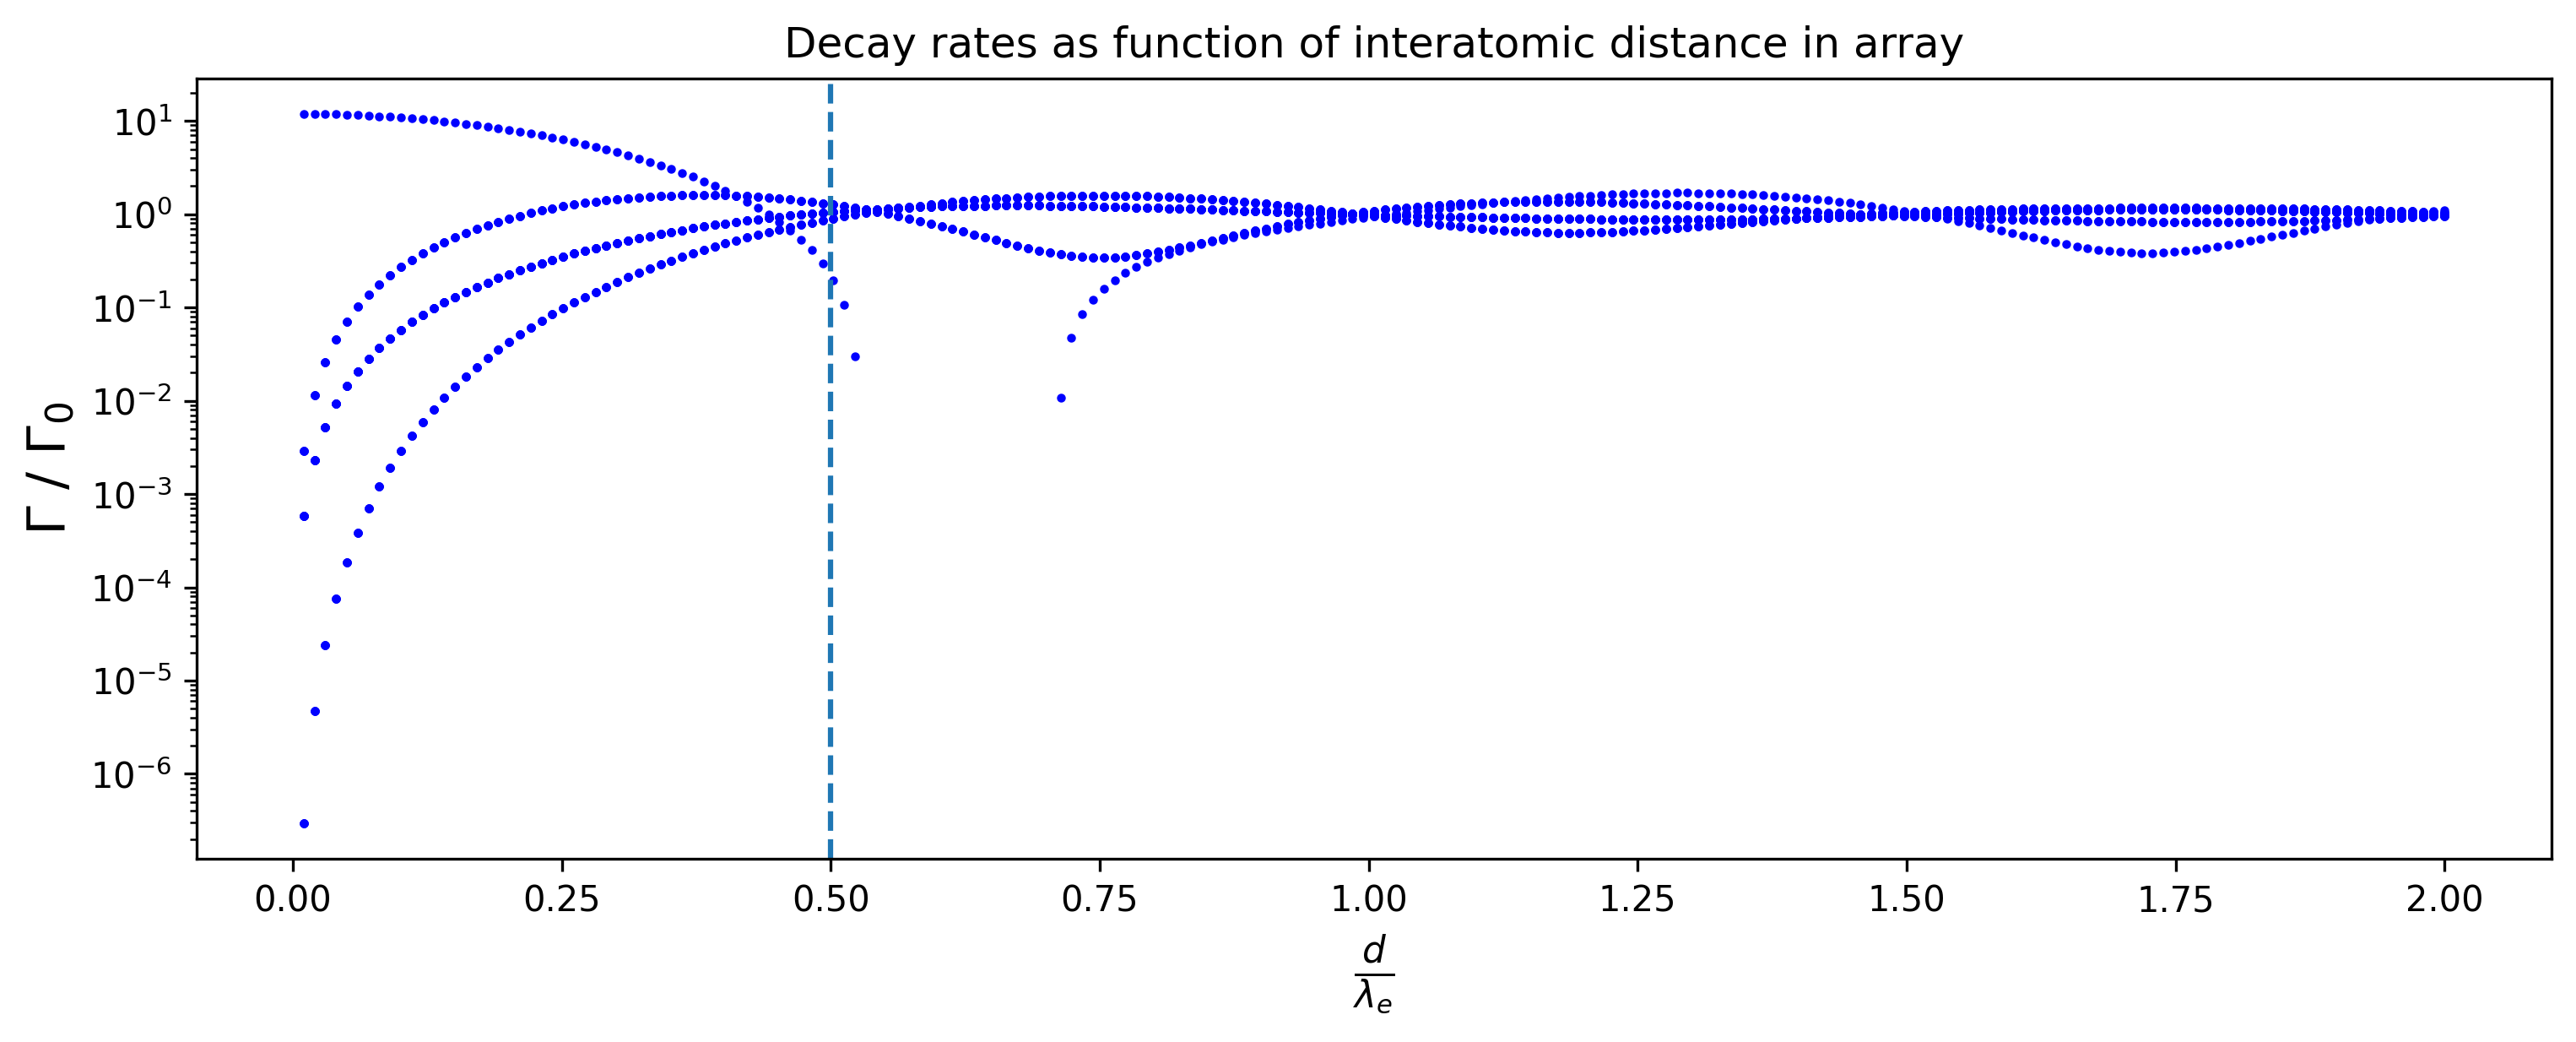

In [38]:
decay_rate_list_hedge = []
most_subradiant_list = []
distances = np.linspace(0, 2, 200)

for d in distances[1:]:
    eigvals_sphere12 , eigvec_sphere12 = Qchains.EigenstatesHedgehog(scaled_sphere_points, unit_polarization, d)
    decay_rate = 2 * eigvals_sphere12.real
    decay_rate_list_hedge.append(decay_rate)

    subradiant = -np.max(2 * eigvals_sphere12.real)
    most_subradiant_list.append(subradiant)
    
decay_rate_list_hedge_reversed = [-p for p in decay_rate_list_hedge]
plt.figure(figsize=(12,4), dpi=300)
plt.plot(distances[1:], decay_rate_list_hedge_reversed, '.', c = 'blue', markersize=3);
plt.xlabel(r'$\frac{d}{\lambda_e}$', size = 15)
plt.ylabel(r'$\Gamma$ / $\Gamma_0$', size = 15)
plt.axvline(x = 1/2, ymin = 0, ymax=3, linestyle = '--')
plt.title('Decay rates as function of interatomic distance in array')
plt.yscale('log')
#plt.ylim(0, 4)

Degeneracy looks to be the reason for some of the wierd behaviour. 

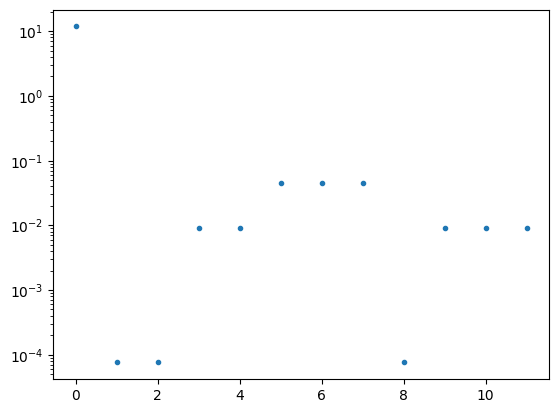

In [39]:
plt.plot(np.array([1.18164680e+01, 7.57978360e-05, 7.57978360e-05, 9.23330217e-03,
        9.23330217e-03, 4.57126941e-02, 4.57126941e-02, 4.57126941e-02,
        7.57978360e-05, 9.23330217e-03, 9.23330217e-03, 9.23330217e-03]), '.')
plt.yscale('log')

#### In the sphere with an atom in the center

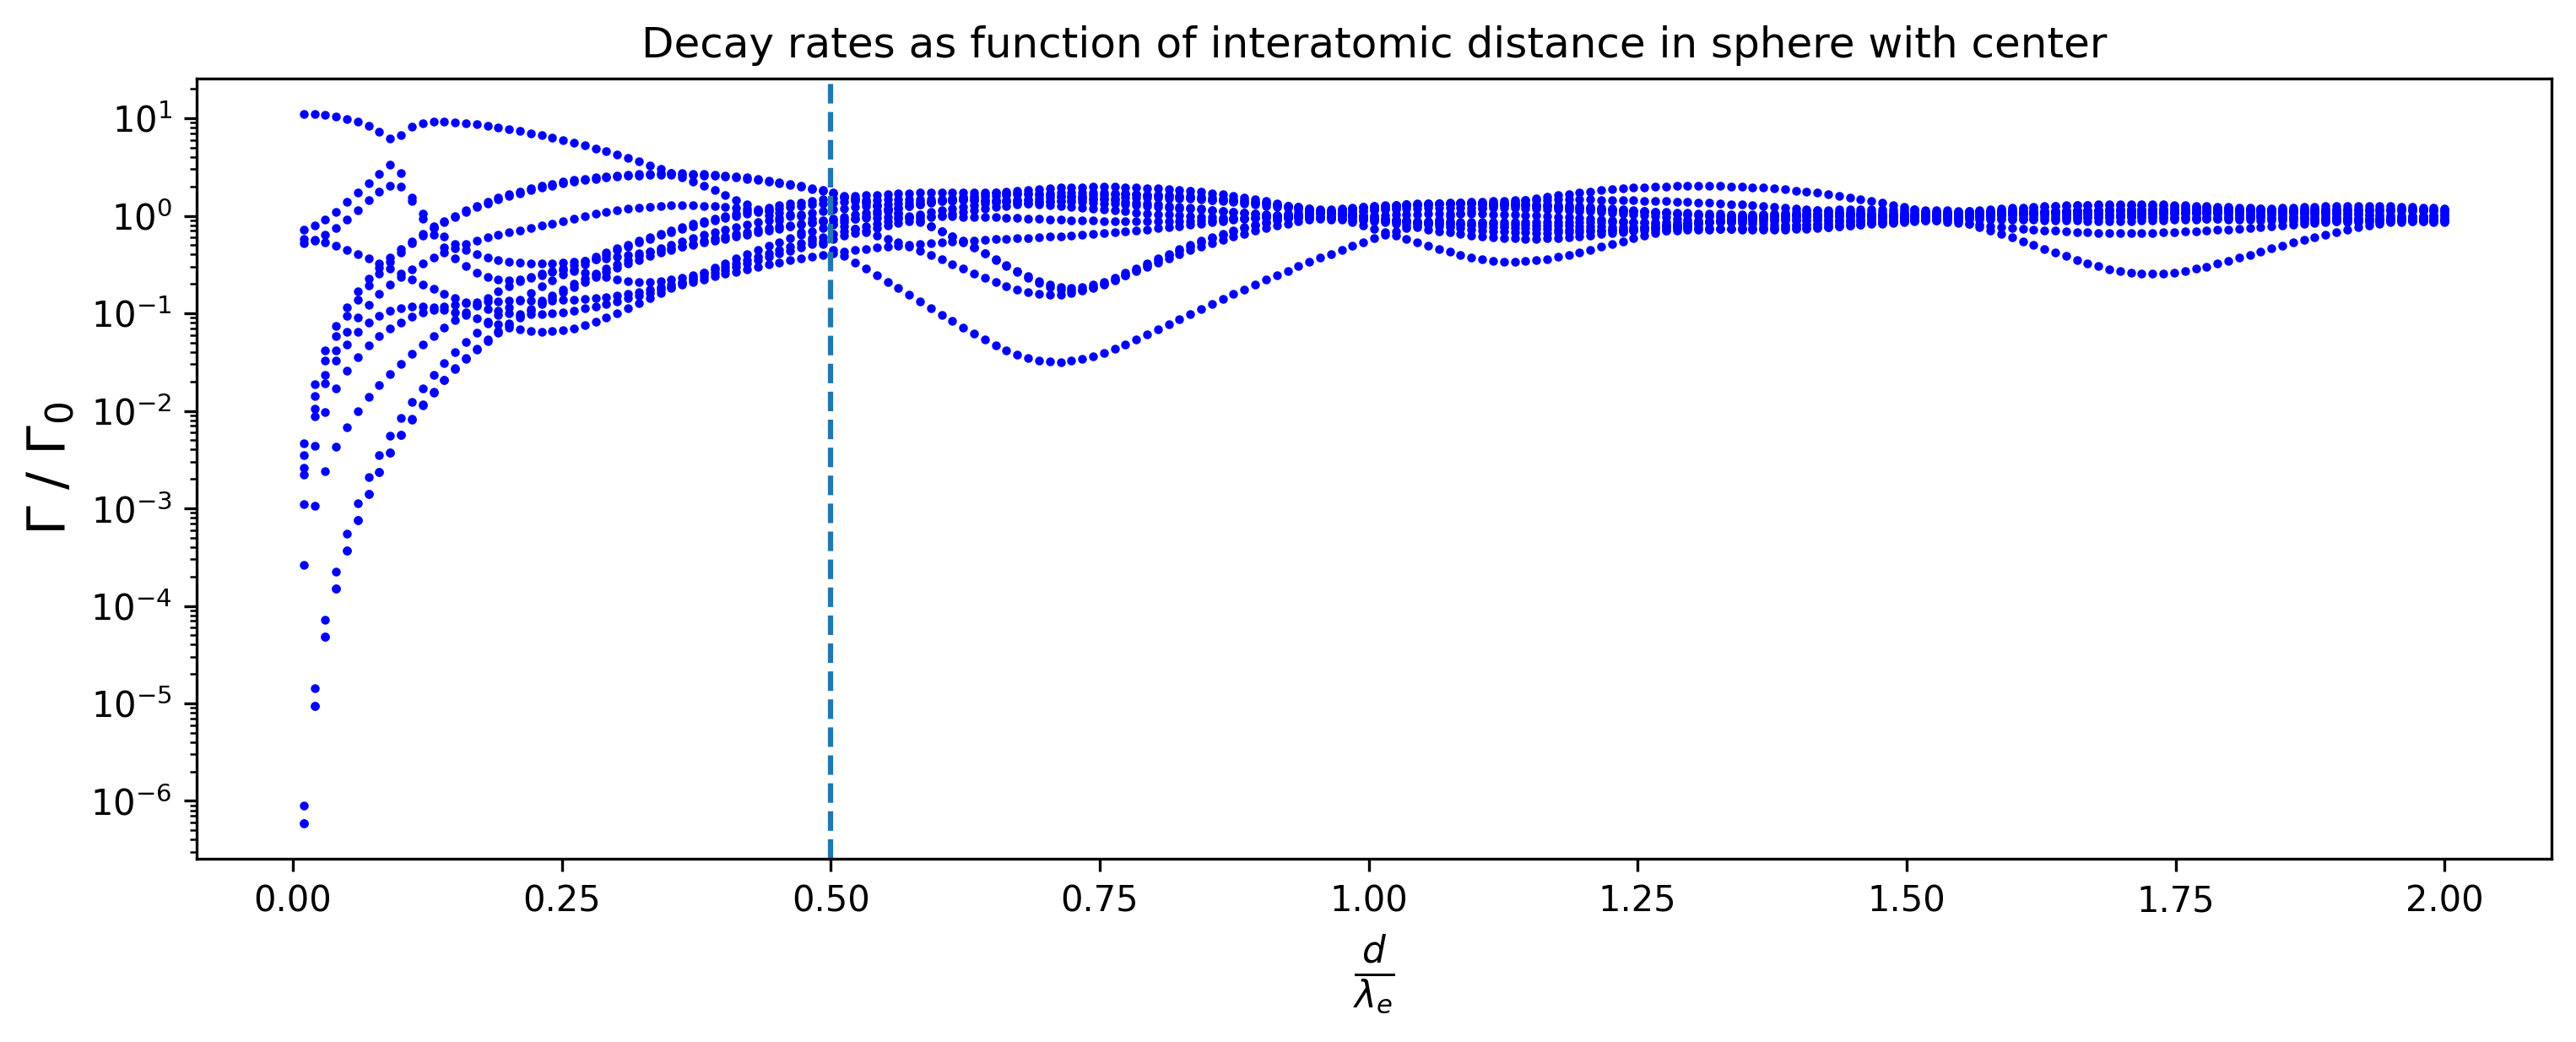

In [40]:
dipole_hatvec = np.array([1, 0, 0])
decay_rate_list = []
most_subradiant_list = []
distances = np.linspace(0, 2, 200) #ik gang med pi, da det gøre i funktionen Qchains.FindEigenstates

for d in distances[1:]:
    eigvals_sphere12 , eigvec_sphere12 = Qchains.FindEigenstates(weird_sphere_scaled, dipole_hatvec, d)
    decay_rate = 2 * eigvals_sphere12.real
    decay_rate_list.append(decay_rate)

    subradiant = -np.max(2 * eigvals_sphere12.real)
    most_subradiant_list.append(subradiant)
    

decay_rate_list_reversed = [-p for p in decay_rate_list]
plt.figure(figsize=(12,4), dpi=300)
plt.plot(distances[1:], decay_rate_list_reversed, '.', c = 'blue', markersize=3);
plt.xlabel(r'$\frac{d}{\lambda_e}$', size = 15)
plt.ylabel(r'$\Gamma$ / $\Gamma_0$', size = 15)
plt.axvline(x = 1/2, ymin = 0, ymax=3, linestyle = '--')
plt.title('Decay rates as function of interatomic distance in sphere with center')
plt.yscale('log')